# Генерация текста с помощью RNN

- на примере генерации имен
- напишем с нуля

(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable     # 2022 deprecated

from IPython.display import clear_output
from random import sample

%matplotlib inline

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

- содержал мусорные строки "To The Next Page"

При загрузке перед каждым именем добавляем пробел:
- если не будет специального символа, с которого начинается генерация, то мы лишим нашу модель способности выбирать первый символ последовательности
  - имеется в виду, что RNN сможет генерировать только только по какому-то образцу (ей нужно хоть что-то подать на вход), например, образец это "A", т.е. сгенерировать имена начинающиеся на А. Поэтому образец " " будет для RNN означать сгенерировать любое имя, т.к. за пробелом в обучающей выборке всегда следует какая-нибудь буква

In [3]:
with open('./datasets/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

In [4]:
MAX_NAME_LENGTH = max(map(len, names))

names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

Посмотрим на распределение длин имен:
- нормальное распределение (ага, если bins побольше указать, а так нет)

(array([5.400e+01, 7.700e+02, 2.943e+03, 3.461e+03, 1.142e+03, 8.570e+02,
        1.410e+02, 1.300e+01, 1.000e+00, 2.000e+00]),
 array([ 3. ,  4.8,  6.6,  8.4, 10.2, 12. , 13.8, 15.6, 17.4, 19.2, 21. ]),
 <BarContainer object of 10 artists>)

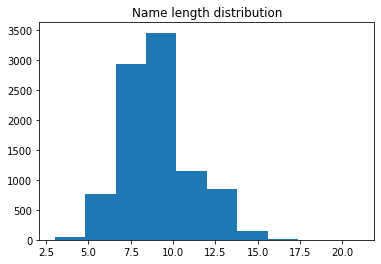

In [5]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)))

In [6]:
from scipy import stats

lnm = np.array(list(map(len, names)))
lnm = (lnm - lnm.mean()) / lnm.std()
stats.kstest(lnm, 'norm')

KstestResult(statistic=0.11361144422982572, pvalue=5.743811551488995e-106)

# Препроцессинг

- составляем список уникальных символов

In [7]:
#all unique characters go here
tokens = list(set(''.join(names)))  # все имена в строку -> множество set()

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  51


### Символы -> id

Создадим словарь < символ > -> < id >

In [8]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [9]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


- переводим имена в векторное представление
- вектора дополняются кодом пробела до максимальной длины (паддинг)

In [10]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [11]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Utropov
[[29 24 11  2 11 46  0 29 29 29]
 [29  4 37  3 37  2 17 37 12 44]
 [29 41 35  2  3 46  0 44 29 29]
 [29  7  2 46 37  2 21 46  3 33]
 [29  8 28 49  0 27  0 44 29 29]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

`initial_state`
- заполняет нулями вектора (просто нулевой 2d тензор)
- соответствует нулевому скрытому состоянию ($h_0$)

`forward`
- преобразовываем наши входные векторы в эмбеддинги с помощью слоя, который мы берём из библиотеки `pytorch`, а именно `nn.Embedding`
- конкатенируем текущий входной вектор из переменной `x_embedding` и скрытое состояние из предыдущего шага
  - конкатенация является простым способом объединить результаты
  - параметр `rnn_num_units` - это размерность промежуточных преобразований
  - это еще один параметр, которым можно играться при обучении модели (кажись, он просто должен быть равен размеру словаря и с ним можно не играться)
- с помощью `rnn_update` (`nn.Linear`), мы делаем следующий шаг — предсказываем следующее скрытое состояние
- к полученному состоянию применяем `torch.tanh` (добавляется нелинейность, к сути RNN не имеет никакого отношения, да и на результат генерации влияет никак, только сходится немного дольше. Вопрос поркуа?)
- и опять его в `nn.Linear`
  - в лекции и в названии переменной сказано "логит", но тут линеар, где y = ln(x/(1-x)) ?
  - In Math, Logit is a function that maps probabilities ([0, 1]) to R ((-inf, inf))
  - Probability of 0.5 corresponds to a logit of 0. Negative logit correspond to probabilities less than 0.5, positive to > 0.5.
  - шо здесь происходит-то???

На выходе:
- новое состояние и `F.log_softmax` от логитов (?)
  - логарифм софтмакса, т.к. логарифмы вероятностей (чтобы численно стабильно считались произведения вероятнотей как сумма логарифмов вероятностей)
- А именно, мы получим 52 (логарифма)вероятности по каждому символу из нашего словаря.

Дополнительные соображения:
- это не логиты, но нечно на них похожее, т.к. это отображение [-1, 1] на (-inf, inf)
- а софтмакс уже отображает (-inf, inf) на [0,1]

In [12]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [13]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

Теперь мы можем начинать тренировку нашей сети, т.е. минимизируя кросс-энтропию, либо максимизируя логарифм правдоподобия нашей модели (что — то же самое) — обучать нашу сеть.


- Берём матрицу ID токенов, сдвинутую на "i" символов влево, так, чтобы именно "i"-ый символ был следующем символом для предсказания на "i"-ом шаге. 
- Такая матрица хранится в переменной "batch index" и, дальше, мы можем переходить к обучению сети.

Короче:
- на последовательность токенов/символов выдает последовательность (логарифмов)вероятностей, что в ГС они бы находились в таком вот порядке

In [14]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [15]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())       # Adaptive Moment Estimation (расширение стох.град.спуска)
history = []

тест работоспособности

In [16]:
batch_ix = to_matrix(sample(names, 16), token_to_id, max_len=MAX_NAME_LENGTH)    # для примера размер 16
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

- Мы делаем "backward pass" — именно здесь мы вычисляем градиенты нашей лосс-функции по параметрам, делаем шаг с помощью "opt.step" и не забываем сделать "zero_grad":
  - если мы не обнулим градиенты, то градиенты из предыдущих шагов будут накапливаться, аккумулироваться, и это приведёт к неправильному обучению сети, т.к.
  - по умолчанию градиенты при каждом вызове loss.backward() аккумулируются, с помощью zero_grad() мы обнуляем градиенты перед новым вызовом backward()
  - такая штука по умолчанию сделана, т.к. в рекуррентных нейронных сетях бывает удобно, ради оптимизации, при вызове backward(), просто прибавлять новый градиент к прежнему значению

Функция потерь:
  - это negative log likelihood loss if reduction=‘mean’, т.е.
  - среднее по предсказанным вероятностям следующих фактических токенов (символов)
    - если все вероятности 1, то минимальная обратная функция правдоподобия (с усреднением) = 0
    - но тут обр.логарифм вероятности, т.е. обратные вероятности, поэтому значение функции потерь снижиется с 4 (средняя вероятность 0.25) до 1 (вероятность 1), т.е. близкое к идеальному узнавание классов (в данном случае символов)
    - $ logit = \ln \frac{p}{1-p}, p = \frac {1}{1 + e^{-L}} $ - это как-то связано с этим
  - минимизация градиентным спуском обратной функции правдоподобия это есть максимизация функции правдоподобия

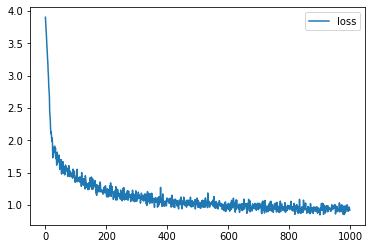

In [17]:
for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_NAME_LENGTH)    # размер батча 32
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()             # градиент функции потерь inplace
    opt.step()                  # шаг по градиенту
    opt.zero_grad()             # не сохранять этот градиент, потому что будет новый
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

Для этого нам, всего лишь, нужно несколько раз сделать forward pass в цикле, предсказать несколько символов и сконкатенировать их в одно слово. 

In [18]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_NAME_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [19]:
print(*[generate_sample(char_rnn).strip() for _ in range(10)])

Rosn Lnyajechetoto Harain Eabranov Merkuev Abolinov heyun Madin aelea Baeilovstsky


Можем осуществить генерацию имён, которые начинаются с определённого набора символов

In [20]:
print(*[generate_sample(char_rnn, seed_phrase=' Ar').strip() for _ in range(10)])

Archinin Aruzov Arelyakyn Ardkev Artzhin ArgakhiBev Arbenov Aronkov Ardazkin Arlumoff


Также мы можем менять такой параметр, как **температура**.
- Если же мы ставим большую температуру, то наша сеть будет генерировать очень разнообразный выход, но при этом, зачастую, достаточно нелогичный, потому что она могла выучить некоторые странные особенности нашего датасета.
- Если мы ставим маленькую температуру, сеть будет генерировать такие фамилии в которых она наиболее уверена.
- задача — выбрать такую температуру, которая будет обеспечивать достаточное разнообразие нашего датасета и, при этом, генерировать логичные фамилии и логичные имена.

**Температура** – это такой общий полу-эмпирический момент в алгоритмах стохастической оптимизации (например, "симулированного отжига"). Этот параметр определяет вклад случайности в результат оптимизации. При высокой температуре скачки решения в случайном направлении более вероятны.


Параметр температуры в коде:

    p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

где logp_next - предсказания сети для логарифма правдоподобия следующего символа по всему словарю символов.

**Температура в softmax** - параметр, который отвечает за “случайность” итогового распределения. Если устремить температуру к нулю, итоговое распределение вырождается в one-hot (элемент с максимальным значением выбирается с вероятностью 1.0). Такое поведение согласуется и с физическими явлениями. С возрастанием температуры энтропия (мера хаотичности) системы растет, а значит события становятся более случайными (т.е. распределение стремится к равномерному).

Получается, чем ниже температура, тем больше будут отличатся вероятности одних символов от других, и наоборот. А символ выбирается далее в следующей строке:

    next_ix = np.random.choice(len(tokens), p=p_next)

- При температуре, стремящейся к бесконечности, генерация любого символа имеет примерно одинаковую вероятность
- При очень маленькой температуре есть вероятность получать каждый раз один и тот же результат
- Чем ниже температура генерации, тем выше уверенность модели в сгенерированных результатах и ниже разнообразие сгенерированной выборки

In [21]:
print(*[generate_sample(char_rnn, seed_phrase=' Ar', temperature=0.2).strip() for _ in range(10)])
print(*[generate_sample(char_rnn, seed_phrase=' Ar', temperature=2).strip() for _ in range(10)])
print(*[generate_sample(char_rnn, seed_phrase=' Ar', temperature=0.01).strip() for _ in range(10)])

Arakhanov Arorov Arorov Arolov Aralanov Aranov Arorov Arorov Arovin Arorov
AryjUy            c ArMnaHoLh Arjiticv           o ArhiMinich isi Arzv egevz         c ArtBo        v  t ArMutkskyv   ilgicsk Ararkop acf UVkyeli Aru Ti  frkoviscyhlk Arday Ridosoncy  a
Arorov Arorov Arorov Arorov Arorov Arorov Arorov Arorov Arorov Arorov


# Более надежное решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [22]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        # assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

Проверка работоспособности:
- решение более простое, но сирамно нужно пошаманить с размерностями данных (тензоры стали толще не 1 измерение)
- начальное состояние тут не нужно, торч сам чето по-умолчанию придумывает...
  
`Variable` это надстройка над `Tensor`, которая позволяет подсчитывать градиенты для обратного распространения ошибки `.backward()`

`Variable API is deprecated!` Теперь тензора включают все из Variable

In [23]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_NAME_LENGTH)
batch_ix = torch.LongTensor(batch_ix)   # int64

logp_seq = model(batch_ix)

# compute loss (!!! тут были перепутаны индексы, логиты данного шага сравниваются со следующими токенами)
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

Почему теперь обучение сходится к 0?
- потому что в `F.nll_loss` была какая-то херомантия
- теперь ОК
- обучение на cpu на 20% быстрее
- добавлена cuda (еще в 5 раз быстрее)

In [24]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))
    

def fit(model, data, token_to_id, opt, steps=1000, batch_size=32, draw=True, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    for i in range(steps):
        batch_ix = to_matrix(sample(data, batch_size), token_to_id)
        batch_ix = Variable(torch.LongTensor(batch_ix))
        batch_ix = copy_data_to_device(batch_ix, device)
        
        logp_seq = model(batch_ix)                                                  # num_tokens вер-тей по кажд.токену в кажд.примере батча
        
        # compute loss
        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, num_tokens)       # предсказанные логиты вероятностей следующих токенов
        actual_next_tokens = batch_ix[:, 1:].contiguous().view(-1)                  # фактические следующие токены (целевые)
        loss = F.nll_loss(input=predictions_logp, target=actual_next_tokens)        # среднее по логитам целевых токенов
        # loss = -torch.mean(torch.gather(predictions_logp, dim=1, index=actual_next_tokens[:, None]))
        
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        history.append(loss.detach().cpu().numpy())
        if draw and (i + 1) % 100 == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()

    assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

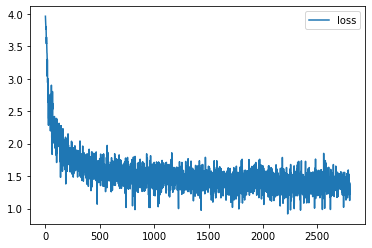

KeyboardInterrupt: 

In [25]:
fit(model, names, token_to_id, opt, steps=3000)

Генератор тоже надо чуть поправить, т.к. размерности тут другие

In [ ]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_NAME_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    model.to(torch.device("cpu"))   # модель и ее данные должны быть на одном устройстве
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.LongTensor([x_sequence])

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next = model.forward(x_sequence)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0, -1]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:

print(*[generate_sample(model).strip() for _ in range(10)])

Dedzuly n Vernmitovnev Geryakhiv Chukunov Baibesrinh Shokhanufb A'vchev Dagaluk Maretnin Milolatofn


# Домашнее задание: мотивационные лозунги

# 1 слой

Данные и словарь

In [ ]:
with open('./datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)


MAX_QUOTE_LENGTH = max(map(len, quotes))

lens = np.array(list(map(len, quotes)))
mean_len = lens.mean()
std_len = lens.std()

print(f"{MAX_QUOTE_LENGTH=}\n{num_tokens=}\n{mean_len=}\n{std_len=}\n", *quotes[:5], sep="\n")

MAX_QUOTE_LENGTH=409
num_tokens=85
mean_len=131.5381169639154
std_len=73.02224087402179

 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.
 Did you ever stop to think, and forget to start again?
 Organizing is what you do before you do something, so that when you do it, it is not all mixed up.
 Weeds are flowers too, once you get to know them.


Модель и обучение (5 минут)

- emb_size - размерность векторного представления последовательности (по идее должна быть больше среднего размера элемента в обучающей выборки)
- rnn_num_units - количество ячеек в слое RNN (аналог объема памяти)

In [ ]:
model_quotes = CharRNNLoop(num_tokens=num_tokens, emb_size=16, rnn_num_units=64, num_layers=1)
opt = torch.optim.Adam(model_quotes.parameters())
history = []

# test
batch_ix = to_matrix(sample(quotes, 16), token_to_id)
batch_ix = torch.LongTensor(batch_ix)   # int64

logp_seq = model_quotes(batch_ix)

# compute loss (!!! тут были перепутаны индексы, логиты данного шага сравниваются со следующими токенами)
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

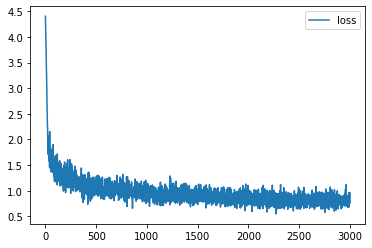

In [ ]:
fit(model_quotes, quotes, token_to_id, opt, steps=2000)

- результат

In [ ]:
for _ in range(10):
    li = round(np.random.randn() * np.sqrt(std_len) + mean_len)
    print('-> ', generate_sample(model_quotes, max_length=li))

->   Whe mu, woetige that min't and to punest that scrooly? of thathig, Betle id:ime. Me dihing bothated bedyine farn dondssions. Endolk
->   I've. Yor singly.                                                                                                                          
->   There ibrells thit unow stashion diss: we I gruald and lomece to was. I can make just filu think Bild.                                
->   In't then whot dies an versec tromed, sforsyop as opt litn't was o youres.                                                            
->   I rorked the dowtry-can ane wordman my partorixo. It's a low the in unlody tha cart afpast ofbort are with. It worker in to b
->   I do dewsowing dosting to aljuctFor much and the erligiat to I'm being and rewrent to nealline in ang samat sspreacan a bact in vase, a.
->   I mover tive the fore couls masguideens lifutile given neurc there ame the goevel, mocative frolores cering.                               
->   I side tind a d

# Больше слоев

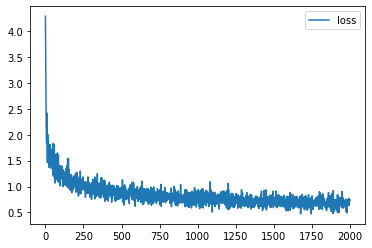

In [ ]:
model_quotes2 = CharRNNLoop(num_tokens=num_tokens, emb_size=32, rnn_num_units=128, num_layers=2)
opt = torch.optim.Adam(model_quotes2.parameters())
history = []

fit(model_quotes2, quotes, token_to_id, opt, steps=2000)

In [ ]:
for _ in range(10):
    li = round(np.random.randn() * np.sqrt(std_len) + mean_len)
    print('-> ', generate_sample(model_quotes2, max_length=li))

->   The been than this own such goes great mean an - the that we don't not acchiounding a graces.                        
->   We addient.                                                                                                                                       
->   Jool clange your had new them't can main tomen't are son baggible that whach a writiin, And larditiv. I jook an all a sicualle midtent
->   Gomen've to fut of by that asAgicandaliath his otherse with You're to truther: one for get Jeils.                                           
->   Stute everyudure, and be some a are youse that's a ride to to just scational, know than Everybody withers.                             
->   Goundia ofter anysole the was of gron you go apporce of the going to more in the right days get times with the noint wh
->   I think, we ait's eiving to really, by hark he Vear, blay so scullard the is dewint it of always everysting mandious with it. I made throug
->   When they paged basures

# Еще больше слоев


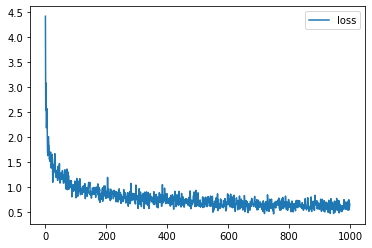

In [ ]:
model_quotes3 = CharRNNLoop(num_tokens=num_tokens, emb_size=64, rnn_num_units=512, num_layers=3)
opt = torch.optim.Adam(model_quotes3.parameters())
history = []

fit(model_quotes3, quotes, token_to_id, opt, steps=1000)

In [ ]:
for _ in range(10):
    li = round(np.random.randn() * np.sqrt(std_len) + mean_len)
    print('-> ', generate_sample(model_quotes3, max_length=li))

->   The most to me it is films to stereform of them tryord Aumins pocephonic worts.                                                     
->   Our government.                                                                                                                            
->   I prefer good trying to wish reverved.                                                                                       
->   The answer awasts and years try to relevel next on the choos of Yor. They time as a lew their right.          
->   Sicate abrects is novelier is the day is sends omemin - live matter of virst disegre.                                                         
->   How work because I'm event. What I give contrums, but changes of our not kill street to repossiblling prossss. Any and people 
->   A mother when I can tell a teath Danning, prissed having ccrose., charbed light which see its perfice. Anvest something in the bess or disa
->   There's a little where actually guncter 

### Что еще можно генерировать?
С помощью кода из этого семинара можно генерировать не только имена, но и:

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.

__Удачи!__